In [1]:
import os
from collections import OrderedDict, namedtuple
from copy import deepcopy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np
import h5py

from nengo_learn_assoc_mem.paths import data_path

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Reaction Time and Error Rate

In [2]:
react_df = pd.read_csv("data/dat_MEG_clean.txt", sep=" ")

In [3]:
react_df.head()

,Subject,Block,hand,Trial,Fan,Length,PairType,acc,RT
0,5,1,RIGHT,2,1,Short,RPFoil,1,2214
1,5,1,RIGHT,3,1,Short,Target,1,1036
2,5,1,RIGHT,4,2,Short,RPFoil,0,1170
3,5,1,RIGHT,5,1,Short,RPFoil,1,1093
4,5,1,RIGHT,6,2,Long,RPFoil,1,2139


In [4]:
all_blocks = react_df[react_df["Subject"] == 5]["Block"].unique()
print(all_blocks.min(), all_blocks.max())

all_trials = react_df[react_df["Subject"] == 5]["Trial"].unique()
print(all_trials.min(), all_trials.max())

1 14
1 64


In [156]:
print(14*64/4 * 0.2)
print(14*64/4 * 0.075)

44.800000000000004
16.8


## RT changing with rehearsal

In [110]:
mean_rt_per_blk = react_df[(react_df["Subject"] == 5) & (react_df["Fan"] == 1)].groupby("Block").mean()["RT"]

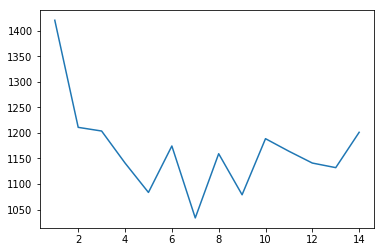

In [111]:
plt.plot(mean_rt_per_blk)

Block 2 is a real outlier and makes it seem like a general decline over time if you include it in a comparison split.

Text(0.5,0,'Pair Type')

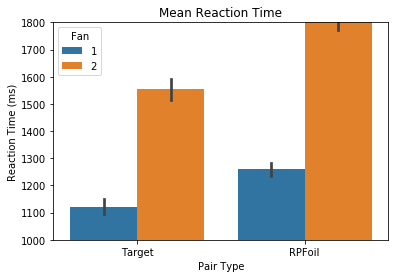

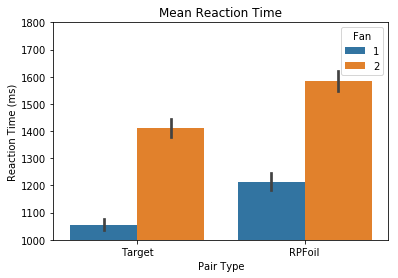

In [117]:
plt.figure()
ax = sns.barplot(x="PairType", y="RT", hue="Fan", data=react_df[(react_df["Block"] > 1) & (react_df["Block"] <= 7)])
ax.set_title("Mean Reaction Time")
ax.set_ylabel("Reaction Time (ms)")
ax.set_ylim(1000, 1800)
ax.set_xlabel("Pair Type")

plt.figure()
ax = sns.barplot(x="PairType", y="RT", hue="Fan", data=react_df[(react_df["Block"] > 7)])
ax.set_title("Mean Reaction Time")
ax.set_ylabel("Reaction Time (ms)")
ax.set_ylim(1000, 1800)
ax.set_xlabel("Pair Type");

In [70]:
model_rt = pd.read_hdf(os.path.join(data_path, "react_err_dfs", "rt.h5"), key="react")

In [71]:
model_rt.head()

,fan1,fan2,foil1,foil2
0,119.4375,119.7500,121.000,117.1250
1,112.0000,112.0000,112.000,112.0000
2,120.1875,120.1875,120.375,118.6250
3,118.0000,117.3750,118.000,118.0000
4,123.0625,124.0000,123.375,121.9375


In [72]:
t_len = len(model_rt.fan1)

In [73]:
fan1_df = pd.DataFrame(np.array([model_rt.fan1, ["Target"]*t_len, [1]*t_len]).T, columns=("RT", "PairType", "Fan"))
fan2_df = pd.DataFrame(np.array([model_rt.fan2, ["Target"]*t_len, [2]*t_len]).T, columns=("RT", "PairType", "Fan"))
foil1_df = pd.DataFrame(np.array([model_rt.foil1, ["RPFoil"]*t_len, [1]*t_len]).T, columns=("RT", "PairType", "Fan"))
foil2_df = pd.DataFrame(np.array([model_rt.foil2, ["RPFoil"]*t_len, [2]*t_len]).T, columns=("RT", "PairType", "Fan"))

new_model_rt = pd.concat((fan1_df, fan2_df, foil1_df, foil2_df))
new_model_rt["RT"] = new_model_rt["RT"].astype(float)
new_model_rt["Fan"] = new_model_rt["Fan"].astype(int)

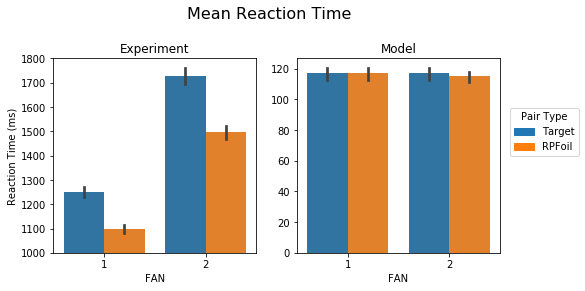

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

sns.barplot(x="Fan", y="RT", hue="PairType", data=react_df, ax=ax1)
ax1.set_title("Experiment")
ax1.set_ylabel("Reaction Time (ms)")
ax1.set_ylim(1000, 1800)
ax1.set_xlabel("FAN")
ax1.legend_.remove()

sns.barplot(x="Fan", y="RT", hue="PairType", data=new_model_rt, ax=ax2)
ax2.set_xlabel("FAN")
ax2.set_ylabel("")
ax2.set_title("Model")

leg_handles = [mpatches.Patch(color="C0", label="Target"),
               mpatches.Patch(color="C1", label="RPFoil")
]
ax2.legend(handles=leg_handles, title="Pair Type", loc=(1.05, 0.5))

plt.suptitle("Mean Reaction Time", fontsize=16)
plt.subplots_adjust(top=0.8)
plt.savefig(os.path.join("plots", "react_time.pdf"), format="pdf", bbox_inches="tight")

In [143]:
res = react_df["acc"].groupby([react_df["Block"], react_df["Subject"], react_df["Fan"], react_df["PairType"]]).mean()

In [144]:
block_df = pd.DataFrame(res).reset_index()
block_df['err'] = 1.0 - block_df['acc']
block_df.head()

,Block,Subject,Fan,PairType,acc,err
0,1,5,1,RPFoil,1.000000,0.000000
1,1,5,1,Target,1.000000,0.000000
2,1,5,2,RPFoil,0.800000,0.200000
3,1,5,2,Target,0.714286,0.285714
4,1,9,1,RPFoil,1.000000,0.000000


/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


(0.0, 0.2)

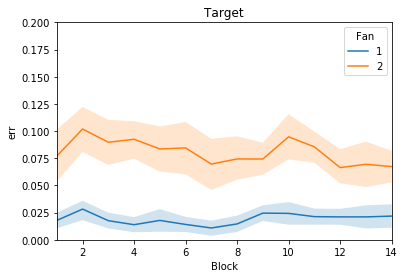

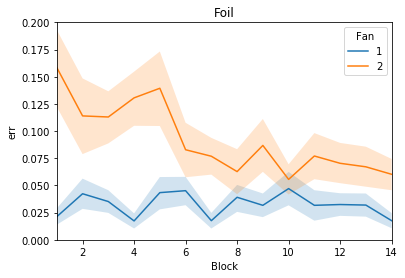

In [152]:
plt.figure()
ax = sns.tsplot(time="Block", value="err", unit="Subject", condition="Fan", data=block_df[block_df["PairType"] == "Target"])
plt.title("Target")
ax.set_ylim(0., 0.2)

plt.figure()
ax = sns.tsplot(time="Block", value="err", unit="Subject", condition="Fan", data=block_df[block_df["PairType"] == "RPFoil"])
plt.title("Foil")
ax.set_ylim(0., 0.2)

Despite looking like an outlier, the Block 1 doesn't actually affect the error rate that much in terms of confidence intervals.

In [60]:
res = react_df[react_df["Block"] > 1]["acc"].groupby([react_df["Subject"], react_df["Fan"], react_df["PairType"]]).mean()

In [61]:
subj_df = pd.DataFrame(res).reset_index()
subj_df['err'] = 1.0 - subj_df['acc']
subj_df.head()

,Subject,Fan,PairType,acc,err
0,5,1,RPFoil,0.951456,0.048544
1,5,1,Target,0.970732,0.029268
2,5,2,RPFoil,0.819512,0.180488
3,5,2,Target,0.887255,0.112745
4,9,1,RPFoil,0.990196,0.009804


In [65]:
model_err = pd.read_hdf(os.path.join(data_path, "react_err_dfs", "err.h5"), key="error")

In [66]:
model_err.head()

,fan1,fan2,foil1,foil2
0,0.0625,0.0625,0.0,0.3750
1,0.0000,0.0000,0.0,0.2500
2,0.0000,0.0000,0.0,0.0000
3,0.0000,0.0000,0.0,0.0000
4,0.0000,0.0000,0.0,0.0625


In [67]:
t_len = len(model_err.fan1)

In [75]:
fan1_df = pd.DataFrame(np.array([model_err.fan1, ["Target"]*t_len, [1]*t_len]).T, columns=("Err", "PairType", "Fan"))
fan2_df = pd.DataFrame(np.array([model_err.fan2, ["Target"]*t_len, [2]*t_len]).T, columns=("Err", "PairType", "Fan"))
foil1_df = pd.DataFrame(np.array([model_err.foil1, ["RPFoil"]*t_len, [1]*t_len]).T, columns=("Err", "PairType", "Fan"))
foil2_df = pd.DataFrame(np.array([model_err.foil2, ["RPFoil"]*t_len, [2]*t_len]).T, columns=("Err", "PairType", "Fan"))

new_model_err = pd.concat((fan1_df, fan2_df, foil1_df, foil2_df))
new_model_err["Err"] = new_model_err["Err"].astype(float)
new_model_err["Fan"] = new_model_err["Fan"].astype(int)

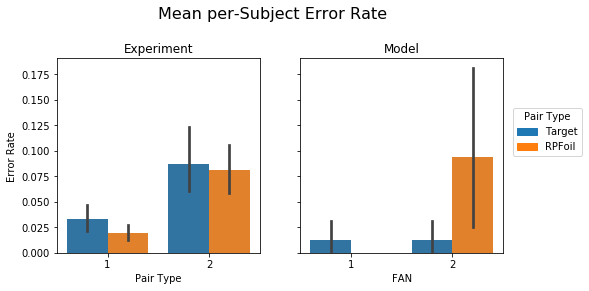

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4))

ax1 = sns.barplot(x="Fan", y="err", hue="PairType", data=subj_df, ax=ax1)
ax1.set_title("Experiment")
ax1.set_ylabel("Error Rate")
ax1.set_xlabel("Pair Type")
ax1.legend_.remove()

sns.barplot(x="Fan", y="Err", hue="PairType", data=new_model_err, ax=ax2)
ax2.set_xlabel("FAN")
ax2.set_ylabel("")
ax2.set_title("Model")

leg_handles = [mpatches.Patch(color="C0", label="Target"),
               mpatches.Patch(color="C1", label="RPFoil")
]
ax2.legend(handles=leg_handles, title="Pair Type", loc=(1.05, 0.5))

plt.suptitle("Mean per-Subject Error Rate", fontsize=16)
plt.subplots_adjust(top=0.8)
plt.savefig(os.path.join("plots", "error_rate.pdf"), format="pdf", bbox_inches="tight")

# MEG data

## Experimental data

In [105]:
file_names = ("recollection_target_fan1_lh.txt",
              "recollection_target_fan2_lh.txt",
              "recollection_foil_fan1_lh.txt",
              "recollection_foil_fan2_lh.txt")
stim_types = ("FAN1", "FAN2", "RPFoil1", "RPFoil2")
win = 50

In [106]:
arr_list = []

for fn in file_names:
    with open(f"data/meg_recall/{fn}", "r") as fi:
        subj_lines = fi.readlines()

    
    arr_list.append(np.array([list(map(float, subj.split(","))) for subj in subj_lines]).T)

In [107]:
meg_dat = np.array(arr_list).T
meg_dat.shape

(18, 251, 4)

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


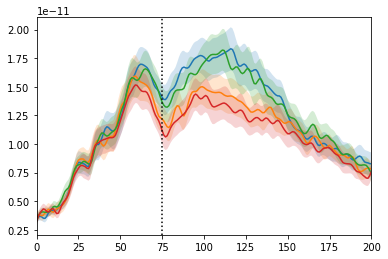

In [108]:
ax = sns.tsplot(data=meg_dat[:, win:])
plt.axvline(75., color="black", linestyle=":")
#plt.gcf().text(0.15, -0.04, "Familiarity", fontsize=14)

old_labels = ax.get_xticklabels()

In [109]:
offset = 200.
new_labels = [((float(xtick.get_text()) + win) / 0.250 - offset) for xtick in ax.get_xticklabels()]
print(new_labels)

[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0]


/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


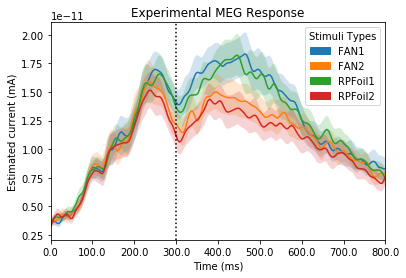

In [110]:
win = 50

ax = sns.tsplot(data=meg_dat[:, win:])

ax.set_ylabel("Estimated current (mA)")
ax.set_xlabel("Time (ms)")

ax.set_xticklabels(new_labels)

leg_handles = [mpatches.Patch(color=f"C{a_i}", label=nm) for a_i, nm in enumerate(stim_types)]

plt.legend(handles=leg_handles, title="Stimuli Types")

plt.title("Experimental MEG Response")
plt.axvline(75., color="black", linestyle=":")
plt.savefig(os.path.join("plots", "recall_meg.pdf"), format="pdf")

## Model data

### Mean Run

In [101]:
static_read_path = os.path.join(data_path, "mixed_static")
neg_read_path = os.path.join(data_path, "neg_voja")

In [102]:
resp_types = [
    ("fan1", []),
    ("fan2", []),
    ("foil1", []),
    ("foil2", [])
]

st_resp = OrderedDict(deepcopy(resp_types))
neg_resp = OrderedDict(deepcopy(resp_types))

In [103]:
for seed_val in range(10):
    with h5py.File(os.path.join(static_read_path, f"static_voja_alt_{seed_val}.h5"), "r") as fi:
        for st_key, st_val in st_resp.items():
            st_val.append(np.array(fi[f"resp/{st_key}"]))

    with h5py.File(os.path.join(neg_read_path, f"neg_voja_alt_{seed_val}.h5"), "r") as fi:
        for neg_key, neg_val in neg_resp.items():
            neg_val.append(np.array(fi[f"resp/{neg_key}"]))

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


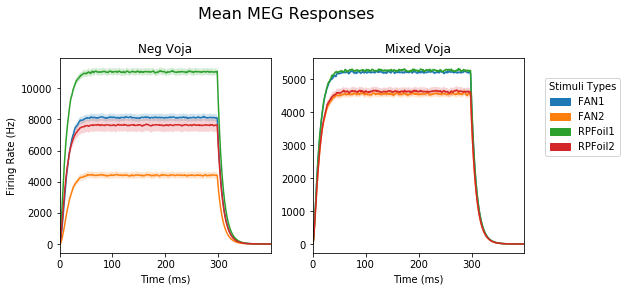

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

ax1.set_title("Neg Voja")
ax1.set_ylabel("Firing Rate (Hz)")
ax1.set_xlabel("Time (ms)")
for r_i, resp in enumerate(neg_resp.values()):
    sns.tsplot(resp, color=f"C{r_i}", ax=ax1)

ax2.set_title("Mixed Voja")
ax2.set_xlabel("Time (ms)")
for r_i, resp in enumerate(st_resp.values()):
    sns.tsplot(resp, color=f"C{r_i}", ax=ax2)

leg_handles = [mpatches.Patch(color=f"C{a_i}", label=nm) for a_i, nm in enumerate(stim_types)]
ax2.legend(handles=leg_handles, title="Stimuli Types", loc=(1.1, 0.5))

plt.subplots_adjust(right=1.2, top=0.8)
plt.suptitle("Mean MEG Responses", fontsize=16, x=.5+.15)
plt.savefig(os.path.join("plots", "avg_meg.pdf"), format="pdf", bbox_inches="tight")

### Single Run

In [77]:
from nengo_learn_assoc_mem.utils import numpy_bytes_to_str, BasicVecFeed, norm_spa_vecs
import nengolib
import nengo
import nengo_spa as spa

In [79]:
stim_types = ("FAN1", "FAN2", "RPFoil1", "RPFoil2")

In [80]:
StimSlc = namedtuple("StimSlc", ['strs', 'vecs', 'slc'])

In [84]:
def get_meg_from_file(load_path: str) -> np.ndarray:
    stim_types = ("fan1", "fan2", "foil1", "foil2")

    stim_strs = []
    
    with h5py.File(load_path, "r") as fi:
        for s_t in stim_types:
            stim_strs.append((s_t, numpy_bytes_to_str(fi[s_t])))

        v_strs = numpy_bytes_to_str(fi['vocab_strings'])
        v_vecs = list(fi['vocab_vectors'])
        dimensions = fi['vocab_vectors'].attrs['dimensions']

        fin_enc = np.array(fi['encoders'])
        n_neurons = fin_enc.shape[0]
        intercepts = fi['encoders'].attrs['intercept']
        seed = fi['encoders'].attrs['seed']

        tm = fi["t_range"]
        dt = tm.attrs["dt"]
        t_pause = tm.attrs["t_pause"]
        t_present = tm.attrs["t_present"]

        t_each = t_pause + t_present
        td_each = int(t_each / dt)
        td_pause = int(t_pause / dt)
        
    vocab = spa.Vocabulary(dimensions)
    for val, vec in zip(v_strs, v_vecs):
        vocab.add(val, vec)
    
    stim_vecs = OrderedDict((
                ("fan1", None),
                ("fan2", None),
                ("foil1", None),
                ("foil2", None)))
    
    last_len = 0
    last_t_len = td_pause

    for (nm, strs) in stim_strs:
        t_diff = td_each * len(strs)
        t_slc = slice(last_t_len, last_t_len + t_diff)
        last_t_len = t_slc.stop

        stim_vecs[nm] = StimSlc(strs, norm_spa_vecs(vocab, strs), t_slc)
    
    feed_vecs = []

    for obj in stim_vecs.values():
        feed_vecs += obj.vecs
    
    feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

    with nengolib.Network(seed=seed) as test_model:
        in_nd = nengo.Node(feed.feed)
        pause = nengo.Node(lambda t: feed.paused)
        meg_nd = nengo.Node(lambda t, x: np.sum(x),
                            size_in=n_neurons, size_out=1)

        ens = nengo.Ensemble(n_neurons, dimensions,
                             encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

        nengo.Connection(in_nd, ens, synapse=None)
        nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)

        nengo.Connection(ens.neurons, meg_nd, synapse=None)

        p_meg = nengo.Probe(meg_nd, synapse=0.01)

    with nengo.Simulator(test_model) as test_sim:
        test_sim.run(len(feed_vecs)*t_each + t_pause)
    
    return test_sim.data[p_meg].squeeze(), stim_vecs

In [85]:
resp_types = (("fan1", None),
              ("fan2", None),
              ("foil1", None),
              ("foil2", None))

load_path = os.path.join(data_path, "neg_voja_enc", "solid_enc_alt_lab.h5")
neg_meg, neg_stim = get_meg_from_file(load_path)

load_path = os.path.join(data_path, "neg_voja_enc", "solid_static_enc.h5")
static_meg, static_stim = get_meg_from_file(load_path)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [99]:
neg_resp = OrderedDict(resp_types)
st_resp = OrderedDict(resp_types)

assert len(neg_meg) == len(static_meg)
for nm, obj in neg_stim.items():
    td_each = int((obj.slc.stop - obj.slc.start) / len(obj.strs))
    neg_resp[nm] = neg_meg[obj.slc].reshape((-1, td_each))

for nm, obj in static_stim.items():
    td_each = int((obj.slc.stop - obj.slc.start) / len(obj.strs))
    st_resp[nm] = static_meg[obj.slc].reshape((-1, td_each))

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


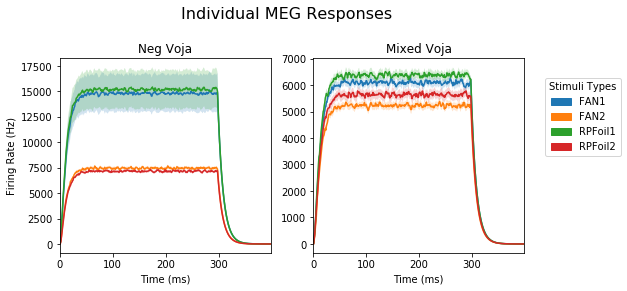

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

ax1.set_title("Neg Voja")
ax1.set_ylabel("Firing Rate (Hz)")
ax1.set_xlabel("Time (ms)")
for r_i, resp in enumerate(neg_resp.values()):
    sns.tsplot(resp, color=f"C{r_i}", ax=ax1)

ax2.set_title("Mixed Voja")
ax2.set_xlabel("Time (ms)")
for r_i, resp in enumerate(st_resp.values()):
    sns.tsplot(resp, color=f"C{r_i}", ax=ax2)

leg_handles = [mpatches.Patch(color=f"C{a_i}", label=nm) for a_i, nm in enumerate(stim_types)]
ax2.legend(handles=leg_handles, title="Stimuli Types", loc=(1.1, 0.5))

plt.subplots_adjust(right=1.2, top=0.8)
plt.suptitle("Individual MEG Responses", fontsize=16, x=.5+.15)
plt.savefig(os.path.join("plots", "individual_meg.pdf"), format="pdf", bbox_inches="tight")